In [1]:
import tensorflow as tf
import numpy as np
import inceptionv3
from utils import *
from defense import *

W0219 15:35:33.643110 139857718232896 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.

In [3]:
orig = load_image('cat.jpg')
TARGET = 924 # guacamole

# Classifier

In [4]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

W0219 15:35:42.169260 139857718232896 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/inceptionv3.py:30: The name tf.image.resize_bilinear is deprecated. Please use tf.compat.v1.image.resize_bilinear instead.

W0219 15:35:42.177628 139857718232896 deprecation.py:323] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/layers/python/layers/layers.py:1057: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
W0219 15:35:44.558017 139857718232896 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/utils.py:14: The name tf.train.NewCheckpointReader is deprecated. Please use tf.compat.v1.train.NewCheckpointReader instead.

W0219 15:35:44.562008 139857718232896 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/utils.py:16: The name tf.global_v

In [5]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

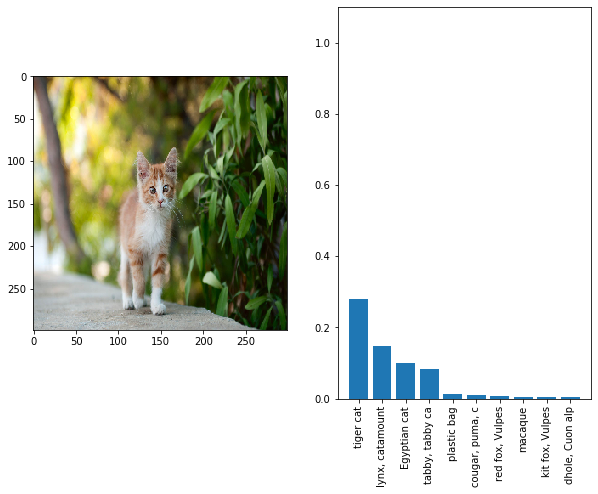

In [6]:
classify(orig, target_class=TARGET)

# Failed attack (attempting to transfer)

In [7]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [8]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=282
step 1, l2=0.000056, pred=277
step 2, l2=0.000075, pred=231
step 3, l2=0.000095, pred=263
step 4, l2=0.000102, pred=274
step 5, l2=0.000115, pred=282
step 6, l2=0.000128, pred=965
step 7, l2=0.000143, pred=924
step 8, l2=0.000152, pred=924
step 9, l2=0.000157, pred=924


In [9]:
cropped_xs = defend_crop(x)
cropped_logits, cropped_preds = inceptionv3.model(sess, cropped_xs)

W0219 15:36:12.446102 139857718232896 deprecation.py:323] From /home/zhouyi/obfuscated-gradients/inputtransformations/defense.py:296: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0219 15:36:12.457639 139857718232896 module_wrapper.py:139] From /home/zhouyi/obfuscated-gradients/inputtransformations/defense.py:300: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0219 15:36:12.469998 139857718232896 deprecation.py:506] From /home/zhouyi/obfuscated-gradients/inputtransformations/defense.py:303: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead


In [14]:
sess.run(cropped_xs)[0][0]

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [299,299,3]
	 [[node Placeholder (defined at /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
	 [[concat/_795]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [299,299,3]
	 [[node Placeholder (defined at /opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'Placeholder':
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/opt/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/opt/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/opt/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-ff0d31ea0fc0>", line 1, in <module>
    x = tf.placeholder(tf.float32, (299, 299, 3))
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [12]:
cropped_probs = tf.reduce_mean(tf.nn.softmax(cropped_logits), axis=0, keepdims=True)
cropped_classify = make_classify(sess, x, cropped_probs)

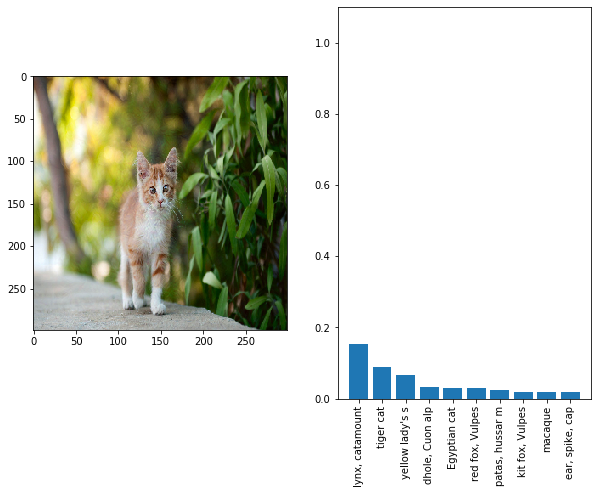

In [13]:
cropped_classify(adv, target_class=TARGET)

# Attack

Using EOT.

In [14]:
cropped_labels = tf.tile(tf.expand_dims(tf.one_hot(TARGET, 1000), axis=0), (cropped_logits.shape[0], 1))
cropped_xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=cropped_logits, labels=cropped_labels))
cropped_loss = cropped_xent + lam * normalized_l2_loss
cropped_grad, = tf.gradients(cropped_loss, x)

<tf.Tensor 'gradients_1/AddN_15:0' shape=(299, 299, 3) dtype=float32>

In [16]:
# PGD

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(50):
    g, l2, p = sess.run([cropped_grad, normalized_l2_loss, cropped_preds], {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    if i % 10 == 0:
        print('step %d, l2=%f, preds=%s' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, preds=[ 95 376 287 282 373 986 274 380 376 274 285 282 364 986 282 986 356 282
 380 986 282 986 986 282 287 278 282 986 287 287]
step 10, l2=0.000096, preds=[924 574 263 282 924 282 287 924 986 924 924 282 924 230 924 924 924 282
 263 924 282 272 574 114 998 924 230 939 924 939]
step 20, l2=0.000178, preds=[924 924 924 924 924 937 924 924 924 924 924 937 924 924 924 924 924 924
 924 924 924 924 923 924 924 924 574 924 924 994]
step 30, l2=0.000199, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 230
 924 965 924 924 924 924 924 924 924 924 924 924]
step 40, l2=0.000215, preds=[924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924 924
 924 924 924 924 924 924 924 924 924 924 924 924]


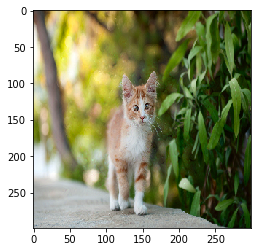

In [14]:
plt.imshow(adv)

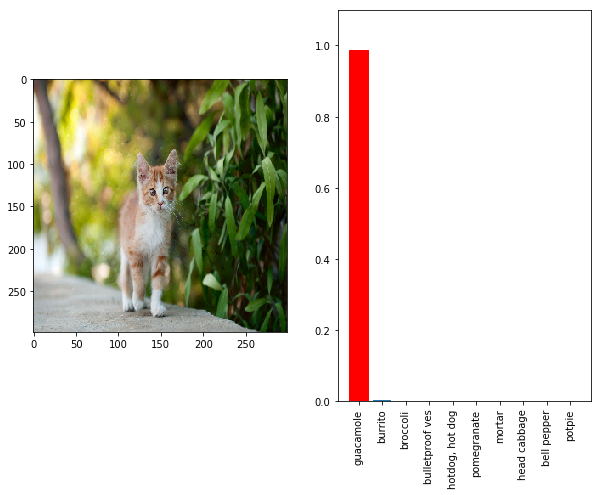

In [15]:
cropped_classify(adv, target_class=TARGET)